In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns

In [19]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [20]:
import data.constants as dc

In [8]:
collection_name = 'week16_densities_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [103]:
[ex for ex in experiments if len(ex['config']['data']['left_out_class_labels']) == 0][0]['result']

{'results': {'val_member_0_cross_entropy-val-0': [0.6442739367485046],
  'val_member_0_accuracy-val-0': [0.8285714387893677],
  'val_member_0_loss-val-0': [0.6442739367485046],
  'ensemble_accuracy-val-0': [0.8285714387893677],
  'accuracy_val__val': [0.8285714387893677],
  'accuracy_id_val__val': [0.8285714387893677],
  'accuracy_ood_val__val': [nan],
  'accuracy_val_no-edges_val': [0.7285714149475098],
  'accuracy_id_val_no-edges_val': [0.7285714149475098],
  'accuracy_ood_val_no-edges_val': [nan],
  'ece_val__val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.1588194572499722}],
  'ece_val_no-edges_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.02646612280181248}],
  'auroc_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8436957514846962}],
  'aucpr_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8470663801104851}],
 

In [11]:
collection = seml.database.get_collection(collection_name)
experiments_unfinished = [{'config' : r['config'], 'id' : r['_id']} for r in collection.find() if r['status'] not in ('COMPLETED',)]

In [15]:
set(ex['config']['model']['use_spectral_norm'] for ex in experiments_unfinished), \
    set(ex['config']['model']['residual'] for ex in experiments_unfinished)

({False}, {False, True})

In [83]:
mode = 'val' # 'test'

In [241]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
DENSITY_MODEL = 'Density Model'
EXPERIMENT = 'Experiment'

# Proxies / Density Model
STRUCTURE = 'Structure'
FEATURE_DISTANCE = 'Feature Distance'
INPUT_DISTANCE = 'Input Distance'
ENTROPY = 'Predictive Entropy'
MAX_SCORE = 'Max Score'
LOGIT_ENERGY = 'Logit Energy'
GPC = 'Gaussian Per Class'
MOG = 'Mixture of Gaussians'
NFPC = 'Normalizing Flow Per Class'
NF = 'Normalizing Flow'

# Fitting to
FIT_TO = 'Fitting'
FIT_TO_MASK = 'Mask'
FIT_TO_ALL = 'All'
FIT_TO_CONF = 'High Score'

# NF types
FLOW_LAYER = 'Layer Type'
RADIAL = 'Radial'
MAF = 'MAF'
NUM_FLOW_LAYERS = 'Layers'
# aggregates info about layers
FLOW_MODEL = 'Flow Model'

# Covariance types
COVARIANCE_TYPE = 'Covariance'
FULL = 'Full'
DIAG = 'Diagonal'
ISO = 'Spherical'
EYE = 'Identity'

# Per class eval modes
PER_CLASS_MODE = 'Class Density'
WEIGHTED = 'Weighted'
MAX = 'Max'

RELATIVE = 'Background'

# MoG initializations
INITIALIZATION = 'Initialization'
RANDOM = 'Random'
PREDICTIONS = 'Predictions'

In [266]:
data = []


for ex in [ex for ex in experiments if not ex['config']['model']['residual'] and not ex['config']['model']['use_spectral_norm']]:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        
    }
    for k, vs in ex['metrics'].items():
        if ('auroc' in k or 'aucpr' in k) and k.endswith('_' + mode):
            if 'auroc' in k:
                metric = AUROC
                k = k.replace('auroc_', '')
            elif 'aucpr' in k:
                metric = AUCPR
                k = k.replace('aucpr_', '')
            else:
                raise ValueError(k)
            
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == 'feature-distance_input':
                metric_cfg[DENSITY_MODEL] = INPUT_DISTANCE
            elif k == 'structure':
                metric_cfg[DENSITY_MODEL] = STRUCTURE
            elif k == 'total-predictive-entropy':
                metric_cfg[DENSITY_MODEL] = ENTROPY
            elif k == 'max-score':
                metric_cfg[DENSITY_MODEL] = MAX_SCORE
            elif k == 'logit-energy':
                metric_cfg[DENSITY_MODEL] = LOGIT_ENERGY
            else:
                # These density models can be fit to different things
                if k.endswith('_fit-mask'):
                    metric_cfg[FIT_TO] = FIT_TO_MASK
                    k = k.replace('_fit-mask', '')
                elif k.endswith('_fit-all'):
                    metric_cfg[FIT_TO] = FIT_TO_ALL
                    k = k.replace('_fit-all', '')
                elif k.endswith('_fit-95conf'):
                    metric_cfg[FIT_TO] = FIT_TO_CONF
                    k = k.replace('_fit-95conf', '')
                else:
                    raise ValueError(k)
                if k == 'feature-distance':
                    metric_cfg[DENSITY_MODEL] = FEATURE_DISTANCE
                else:
                    if not k.endswith(':no'):
                        raise ValueError(k)
                    k = k.replace(':no', '')
                    
                    if k.startswith('gpc'):
                        _, covariance, gpc_mode, relative = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL, 'iso' : ISO, 'eye' : EYE}[covariance],
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[gpc_mode],
                            RELATIVE : {'relative:True' : True, 'relative:False' : False}[relative],
                            DENSITY_MODEL : GPC,
                        }
                    elif k.startswith('mog'):
                        _, components, covariance, initialization = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL}[covariance],
                            INITIALIZATION : {'random' : RANDOM, 'predictions' : PREDICTIONS}[initialization],
                            DENSITY_MODEL : MOG,
                        }
                    elif k.startswith('nfpc'):
                        _, layers, layer_type, _, _, pc_mode, relative = k.split('-')
                        metric_cfg |= {
                            FLOW_LAYER : {'radial' : RADIAL, 'maf' : MAF}[layer_type],
                            NUM_FLOW_LAYERS : layers,
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[pc_mode],
                            RELATIVE : {'relative:True' : True, 'relative:False' : False}[relative],
                            DENSITY_MODEL : NFPC,
                            FLOW_MODEL : f'{layers}-{layer_type}',
                        }
                    elif k.startswith('nf'):
                        _, layers, layer_type, _, _ = k.split('-')
                        metric_cfg |= {
                            FLOW_LAYER : {'radial' : RADIAL, 'maf' : MAF}[layer_type],
                            NUM_FLOW_LAYERS : layers,
                            DENSITY_MODEL : NF,
                            FLOW_MODEL : f'{layers}-{layer_type}',
                        }
                    else:
                        raise ValueError(k)
                
                
            for v in vs:
                v = v['value']
                data.append({
                    metric : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base)




In [267]:
df = pd.DataFrame(data)

array([0.75245051, 0.98360861, 0.39144227, 0.24557301, 0.64928006,
       0.92711217, 0.82167239, 0.21568977, 0.62015349, 0.51599259,
       0.76348546, 0.9151399 , 0.40321108, 0.58647792, 0.0499236 ,
       0.4547011 , 0.83468813, 0.21752499, 0.62147123, 0.45525492,
       0.29997484, 0.15474091, 0.98171723, 0.22385091, 0.10398709,
       0.95845095, 0.56191847, 0.68459432, 0.21885611, 0.72857807])

# GPC

### Transductive

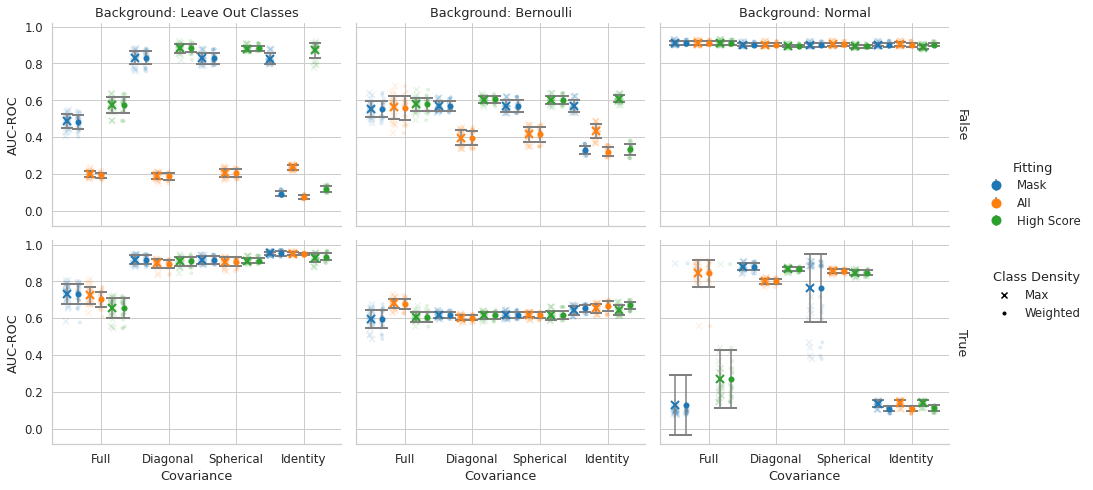

In [259]:
# Extremely hacky plotting...

order_x = [FULL, DIAG, ISO, EYE]
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
styles = ['x', '.']

g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    row = RELATIVE, margin_titles = True,
    
    height=3.5,
    aspect=1.2,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1, .4,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

### Transductive, no edges

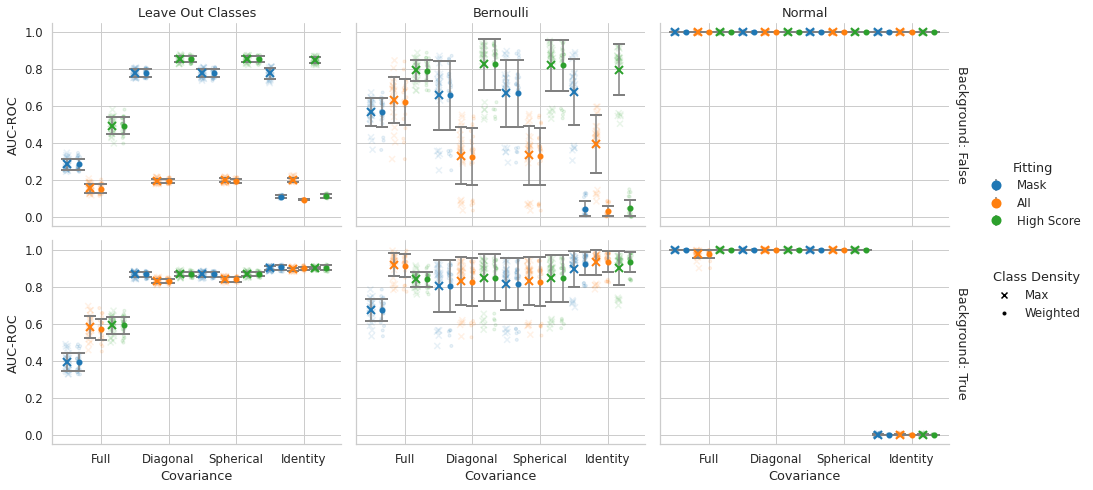

In [260]:
# Extremely hacky plotting...

order_x = [FULL, DIAG, ISO, EYE]
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
styles = ['x', '.']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    row = RELATIVE, margin_titles = True,
    
    height=3.5,
    aspect=1.2,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.2, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1, .4,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

# Normalizing Flows per Class

In [247]:
set(df[FLOW_MODEL])

{'10-maf', '10-radial', '16-maf', '16-radial', '2-maf', '2-radial', nan}

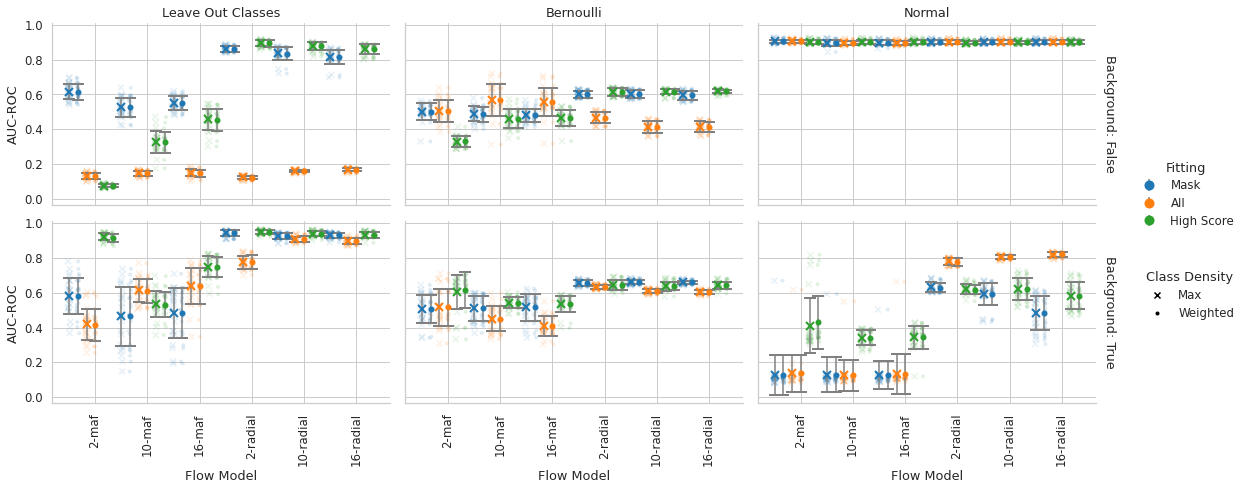

In [261]:
# Extremely hacky plotting...

order_x = ['2-maf', '10-maf', '16-maf', '2-radial', '10-radial', '16-radial']
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']

styles = ['x', '.']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    row = RELATIVE, margin_titles = True,
    
    height=3.5,
    aspect=1.4,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x, rotation=90)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1, .4,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

### No edges

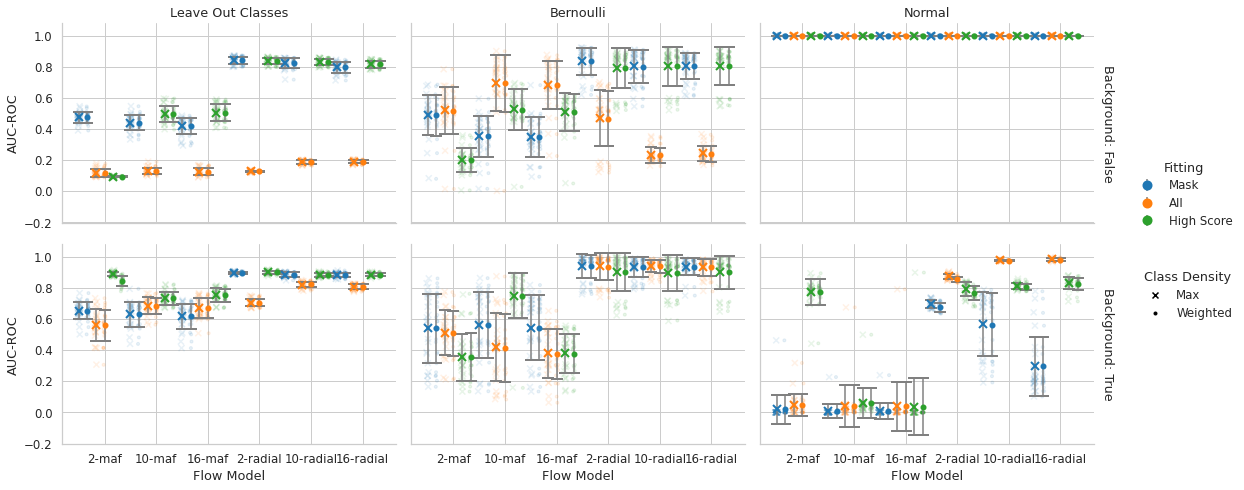

In [262]:
# Extremely hacky plotting...

order_x = ['2-maf', '10-maf', '16-maf', '2-radial', '10-radial', '16-radial']
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
styles = ['x', '.']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    row = RELATIVE, margin_titles = True,
    
    height=3.5,
    aspect=1.4,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1, .4,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

### NF

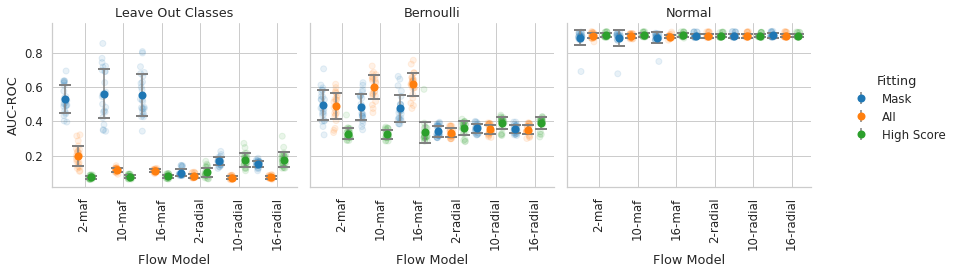

In [284]:
# Extremely hacky plotting...

order_x = ['2-maf', '10-maf', '16-maf', '2-radial', '10-radial', '16-radial']
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        order_all.append(f'{ox}#{oh}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    margin_titles = True,
    
    height=4.0,
    aspect=1.0,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    
    plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
    # Plot means with errorbars
    for xx in np.unique(x_plot[:]):
        yy = (y[(x_plot == xx)].mean())
        err = (y[(x_plot == xx)].std())

        _cs = set(color[(x_plot == xx)])
        assert len(_cs) == 1
        c = (list(_cs)[0])
        plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x, rotation=90)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

### No Edges

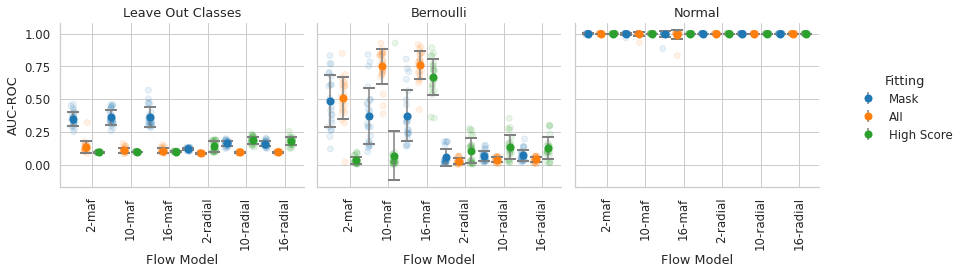

In [285]:
# Extremely hacky plotting...

order_x = ['2-maf', '10-maf', '16-maf', '2-radial', '10-radial', '16-radial']
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [MAX, WEIGHTED]

order_all = []
for ox in order_x:
    for oh in order_hue:
        order_all.append(f'{ox}#{oh}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT, 
    margin_titles = True,
    
    height=4.0,
    aspect=1.0,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    
    plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
    # Plot means with errorbars
    for xx in np.unique(x_plot[:]):
        yy = (y[(x_plot == xx)].mean())
        err = (y[(x_plot == xx)].std())

        _cs = set(color[(x_plot == xx)])
        assert len(_cs) == 1
        c = (list(_cs)[0])
        plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x, rotation=90)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .6,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

## MoG

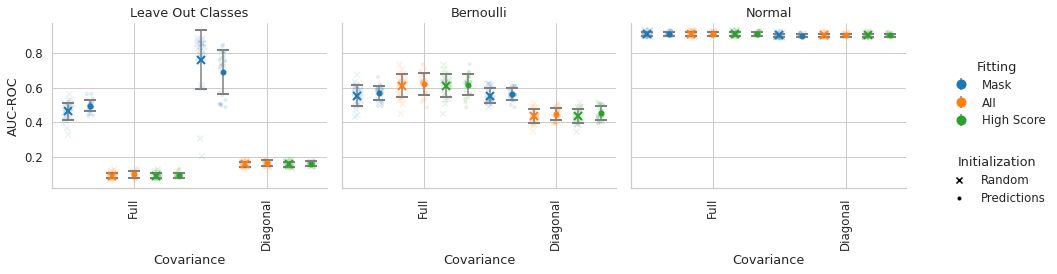

In [286]:
# Extremely hacky plotting...

order_x = [FULL, DIAG]
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [RANDOM, PREDICTIONS]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']

styles = ['x', '.']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT,
    margin_titles = True,
    
    height=4.0,
    aspect=1.0,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x, rotation=90)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .65,))
g.add_legend(artists_style, title=INITIALIZATION, bbox_to_anchor=(1, .35,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')

In [ ]:
# Extremely hacky plotting...

order_x = [FULL, DIAG]
order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
order_style = [RANDOM, PREDICTIONS]

order_all = []
for ox in order_x:
    for oh in order_hue:
        for os in order_style:
            order_all.append(f'{ox}#{oh}#{os}')

hue_colors = ['tab:blue', 'tab:orange', 'tab:green']

styles = ['x', '.']


g = sns.FacetGrid(
    data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
    col = EXPERIMENT,
    margin_titles = True,
    
    height=4.0,
    aspect=1.0,
)

artists_hue = {}
artists_style = {}

def plot_y(x, y, hue, st, color=None, label=None):
    
    x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
    # jitter
    x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
    color = np.array([hue_colors[order_hue.index(h)] for h in hue])
    
    for sidx, s in enumerate(order_style):
        plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[st == s]):
            yy = (y[(st == s) & (x_plot == xx)].mean())
            err = (y[(st == s) & (x_plot == xx)].std())
            
            _cs = set(color[(st == s) & (x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=8, capsize=6, c=c)
            
    # Add empty artists for legends
    for h, color in zip(order_hue, hue_colors):
        artists_hue[h] = plt.errorbar([], [], yerr=[], ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, c=color)
    for s, marker in zip(order_style, styles):
        artists_style[s] = plt.scatter([], [], c='black', marker=marker)
    
    
    width = len(order_all) / len(order_x)
    centers = (np.arange(len(order_x)) * width) + (width / 2)
    
    plt.xticks(ticks=centers, labels=order_x, rotation=90)
    return
    
    
    
    sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))
    
g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1, .65,))
g.add_legend(artists_style, title=INITIALIZATION, bbox_to_anchor=(1, .35,))
g.set_titles(row_template = 'Background: {row_name}', col_template = '{col_name}')